# NLP - Lab 03
## Adrien Giget, Tanguy Malandain, Denis Stojiljkovic

## Introduction to Natural Language Processing 01

### Imports

In [ ]:
import datasets as ds
import numpy as np
from typing import Dict, Any, List, Set, Tuple
import re

import nltk
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

On charge le dataset.

In [ ]:
data = ds.load_dataset("imdb")

On n'utilisera pas ce set de donnnées.

In [3]:
del data["unsupervised"]

On récupère les fonctionnalités de pré-processing du lab précédent.

In [4]:
def get_lower(comment: Dict[str, Any]) -> Dict[str, Any]:
    """
    :param comment: Actual costumer comment as a dict : { str : Any }
    :return: a modified dict : { str : Any }
    """
    comment["text"] = comment["text"].lower()
    return comment

def remove_angle_brackets(comment: Dict[str, Any]) -> Dict[str, Any]:
    """
    Remove everything inside < > characters (usually <br > from scraping)
    :param comment: Actual costumer comment as a dict : { str : Any }
    :return: a modified dict : { str : Any }
    """
    comment["text"] = re.sub(f'<.*?>', '', comment["text"])
    return comment

def remove_unknown_unicode(comment: Dict[str, Any]) -> Dict[str, Any]:
    """
    Remove all non-usual unicode characters (as —)
    :param comment: Actual costumer comment as a dict : { str : Any }
    :return: a modified dict : { str : Any }
    """
    comment["text"] = re.sub(r"(\\x\S+)", '', repr(comment["text"])[1:-1])
    return comment

def remove_backslash(comment: Dict[str, Any]) -> Dict[str, Any]:
    """
    Remove all backslash (usually as "it\'s")
    :param comment: Actual costumer comment as a dict : { str : Any }
    :return: a modified dict : { str : Any }
    """
    comment["text"] = re.sub(r"\\", '', comment["text"])
    return comment

def remove_ponctuation(comment: Dict[str, Any]) -> Dict[str, Any]:
    """
    Remove non-wanted ponctuations as -_\(\)\".,`:;* that don't add much syntactical meaning.
    :param comment: Actual costumer comment as a dict : { str : Any }
    :return: a modified dict : { str : Any }
    """
    comment["text"] = re.sub(r"[-_\(\)\".,`:;*]", ' ', comment["text"])
    comment["text"] = re.sub(r"[(!?)]", r" \g<0> ", comment["text"]) # We want to keep ? and ! in the split
    return comment


stops = set(stopwords.words('english'))


def remove_stop_words(comment: Dict[str, Any], stop_words: Set[str] = stops) -> Dict[str, Any]:
    """
    Remove every english stop words as defined in the nltk package
    :param stop_words: A set of stop words : set[str]
    :param comment: Actual costumer comment as a dict : { str : Any }
    :return: a modified dict : { str : Any }
    """
    words = word_tokenize(comment["text"])
    words_filtered = [w for w in words if w not in stop_words]
    comment["text"] = ' '.join(words_filtered)
    return comment


def remove_all(comment: Dict[str, Any]) -> Dict[str, Any]:
    """
    Apply all above
    :param comment: Actual costumer comment as a dict : { str : Any }
    :return: a modified dict : { str : Any }
    """
    return remove_ponctuation(remove_backslash(remove_unknown_unicode(remove_angle_brackets(get_lower(comment)))))

On réutilise le dataset avec le pré-processing du lab précédent sans retirer les stop_words puisque le mot 'no' est présent dans la liste des stop_words du corpus NLTK donc on va juste faire le pré-processing de la ponctuation et de la casse.

In [ ]:
adapted_data = data.map(remove_all)

## Features (6 points)

(6 points) Code the following features:
   * 1 if "no" appears in the document, 0 otherwise.
   * The count of first and second pronouns in the document.
   * 1 if "!" is in the document, 0 otherwise.
   * Log(word count in the document).
   * Number of words in the document which are in the positive lexicon.
   * Number of words in the document which are in the negative lexicon.
   * [Bonus] Add another feature of your choice.


In [6]:
def has_no(comment: Dict[str, Any]) -> int:
    """
    :param comment: Given comment : { str : Any }
    :return: 1 if 'no' appears in the document, 0 otherwise : int
    """
    
    words = word_tokenize(comment["text"])
    
    for word in words:
        if word == 'no':
            return 1
    
    return 0

In [7]:
def count_pronouns(comment: Dict[str, Any]) -> int:
    """
    :param comment: Given comment : { str : Any }
    :return: Count first and second pronouns : int
    """
    
    words = word_tokenize(comment["text"])
    
    count = 0
    first_n_second_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'you',
                             'your', 'yours', 'yourself'}
    
    for word in words:
        if word in first_n_second_pronouns:
            count += 1
            
    return count

In [8]:
def has_exclamative(comment: Dict[str, Any]) -> int:
    """
    :param comment: Given comment : { str : Any }
    :return: 1 if '!' appears in the document, 0 otherwise : int
    """
    
    words = word_tokenize(comment["text"])
    
    for word in words:
        if word == '!':
            return 1
    
    return 0

In [9]:
def words_count_log(comment: Dict[str, Any]) -> float:
    """
    :param comment: Given comment : { str : Any }
    :return: Log(word count in the document) : float
    """

    words = word_tokenize(comment["text"])
    
    return np.log(len(words))

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [11]:
lex_analyser = SentimentIntensityAnalyzer()

In [12]:
def positive_words(comment: Dict[str, Any]) -> int:
    """
    :param comment: Given comment : { str : Any }
    :return: Number of words in the document which are in the positive lexicon : int
    """
    
    words = word_tokenize(comment["text"])
    
    count = 0
    
    for word in words:
        vs = lex_analyser.polarity_scores(word)
        if vs['pos'] >= 1:
            count += 1
    
    return count

In [13]:
def negative_words(comment: Dict[str, Any]) -> int:
    """
    :param comment: Given comment : { str : Any }
    :return: Number of words in the document which are in the negative lexicon : int
    """
    
    words = word_tokenize(comment["text"])
    
    count = 0
    
    for word in words:
        vs = lex_analyser.polarity_scores(word)
        if vs['neg'] >= 1:
            count += 1
    
    return count

Pour le paramètre de notre choix, nous allons calculer le logarithme du nombre de mots moins les "stop words".

In [14]:
def words_count_log_minus_stop_words(comment: Dict[str, Any]) -> float:
    """
    :param comment: Given comment : { str : Any }
    :return: Log(word count in the document without stop words) : float
    """

    no_stop_comment = remove_stop_words(comment)

    words = word_tokenize(no_stop_comment["text"])

    return np.log(len(words))

Fonction qui applique toutes les fonctions ci-dessus.

In [15]:
def apply_all(comment: Dict[str, Any]) -> Tuple[int, int, int, float, int, int, float]:
    """
    :param comment: Given comment : { str : Any }
    :return: A vector that match all upper functions : Tuple[int, int, int, float, int, int, float]
    """
    return [has_no(comment), count_pronouns(comment), has_exclamative(comment), words_count_log(comment), positive_words(comment), negative_words(comment), words_count_log_minus_stop_words(comment)]

## Optimisation

Re-créer un flow de token pour calculer chaque paramètre de notre vecteur est couteux, alors voici une version plus optimisé calculant tous les paramètres en une seule boucle.

In [16]:
first_second_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'you',
                         'your', 'yours', 'yourself'}

def vectorisation(comment: Dict[str, Any]) -> Tuple[int, int, int, float, int, int, float]:
    """
    :param comment: Given comment : { str : Any }
    :return: A vector that match all upper functions : list[int, int, int, float, int, int, float]
    """
    vector = [0, 0, 0, 0.0, 0, 0, 0.0]

    words = word_tokenize(comment["text"])

    no_stop_comment = remove_stop_words(comment)
    words_no_stop = word_tokenize(no_stop_comment["text"])

    has_no_var = False
    has_exclamative_var = False

    for word in words:
        vs = lex_analyser.polarity_scores(word)

        if not has_no_var and word == 'no':
            vector[0] = 1
            has_no_var = True
        elif word in first_second_pronouns:
            vector[1] += 1
        elif not has_exclamative_var and word == '!':
            vector[2] = 1
            has_exclamative_var = True
        
        if vs['pos'] >= 1:
            vector[4] += 1
        elif vs['neg'] >= 1:
            vector[5] += 1

    vector[3] = np.log(len(words))
    vector[6] = np.log(len(words_no_stop))

    return vector

## Logistic regression classifier (6 points)

### (3 points) Adapt the code by adding your feature extractor and train a classifier.

   * For training, don't use the test set as validation. Instead, split the training set into a training and a validation set (use 10 to 20% of the training set as validation).



In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn

In [18]:
train_points = [vectorisation(comment) for comment in adapted_data["train"]]
test_points = [vectorisation(comment) for comment in adapted_data["test"]]

In [19]:
train_points = torch.tensor(train_points, dtype=torch.float32)
train_labels = torch.tensor(adapted_data["train"]['label'], dtype=torch.float32).reshape(-1, 1)

test_points = torch.tensor(test_points, dtype=torch.float32)
test_labels = torch.tensor(adapted_data["test"]['label'], dtype=torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    train_points,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42,
)

In [20]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [21]:
model_1 = LinearRegression(7, 1)
criterion_1 = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01, weight_decay=0.5)

In [22]:
%%time

def training(optimizer: torch.optim.SGD, model : LinearRegression, criterion = None) -> Tuple[list, list]:
    """
    Training loop.
    :param optimizer: The optimizer to use : torch.optim.SGD
    :param model: The model to train : LinearRegression
    :param criterion: The loss function to use : torch.nn.BCEWithLogitsLoss
    :return: The losses of the training and the validation : Tuple[list, list]
    """
    if criterion is None:
        criterion = nn.BCEWithLogitsLoss()

    n_epochs = 1000

    # Keeping an eye on the losses
    train_losses = []
    test_losses = []

    # Training loop
    for epoch in range(n_epochs):
        # Setting all gradients to zero.
        optimizer.zero_grad()

        # Sending the whole training set through the model.
        predictions = model(X_train)

        # Computing the loss.
        loss = criterion(predictions, y_train)
        train_losses.append(loss.item())

        # Computing the gradients and gradient descent.
        loss.backward()
        optimizer.step()

        # When computing the validation loss, we do not want to update the weights.
        # torch.no_grad tells PyTorch to not save the necessary data used for
        # gradient descent.
        with torch.no_grad():
            predictions = model(X_valid)
            loss = criterion(predictions, y_valid)
            test_losses.append(loss)

    return train_losses, test_losses

train_loss, test_loss = training(optimizer_1, model_1, criterion=criterion_1)

CPU times: total: 1.58 s
Wall time: 912 ms


In [23]:
def test(model : LinearRegression) -> None:
    """
    Test loop.
    :param model: The model to test : LinearRegression
    :return: None
    """
    # Note that we need to use a sigmoid on the output now.
    with torch.no_grad():
        p_train = torch.sigmoid(model(X_train))
        p_train = np.round(p_train.numpy())
        training_accuracy = np.mean(p_train == y_train.numpy())
        p_valid = torch.sigmoid(model(X_valid))
        p_valid = np.round(p_valid.numpy())
        valid_accuracy = np.mean(p_valid == y_valid.numpy())
        p_test = torch.sigmoid(model(test_points))
        p_test = np.round(p_test.numpy())
        test_accuracy = np.mean(p_test == test_labels.numpy())

    print(f'Accuracy of training : {training_accuracy}, valid : {valid_accuracy}, test : {test_accuracy}')

test(model_1)

Accuracy of training : 0.7102, valid : 0.7028, test : 0.71124


On obtient une accuracy de training de 0.7102, de validation de 0.7028 et de test de 0.71124.

### (1 point) Evaluate your classifier in terms of accuracy for the training, validation, and test set.

Le modèle n'est pas très performant, on a une accuracy de 71,025% sur le training, 70,32% sur le validation et 71,11% sur le test.
Sur le lab précédent, on obtenait une accuracy de 90%.

Nous pouvons donc dire que les paramètres de vectorisation, les features, ne sont pas très discriminantes pour prédire ces données.

### (1 point) Look at the weights of your classifier. Which features seems to play most for both classes?

In [24]:
weights = model_1.linear.weight.detach().numpy()
bias = model_1.linear.bias.detach().numpy()[0]

weights = weights.reshape(-1)

print(f'Has no : {weights[0]}, count_pronouns : {weights[1]}, has_exclamative : {weights[2]}, words_count_log : {weights[3]} \n'
      f'positive_words : {weights[4]}, negative_words : {weights[5]}, words_count_log_minus_stop_words : {weights[6]}\n'
      f'bias : {bias}')

Has no : -0.032714568078517914, count_pronouns : -0.03238295018672943, has_exclamative : -0.006759235635399818, words_count_log : -0.011116011999547482 
positive_words : 0.12289740890264511, negative_words : -0.14218854904174805, words_count_log_minus_stop_words : -0.011636937037110329
bias : -0.0019977721385657787


La seule feature qui joue pour la classe positive est le nombre de mots dans le lexique positif.

Toutes les autres features jouent pour la classe négative, plus particulièrement le nombre de mots dans le lexique négatif, ce qui est logique et aussi le nombre de mots dans le commentaire, on peut donc en déduire que dans notre corpus les commentaires négatifs sont plus longs que les commentaires positifs.

Le reste des paramètres jouent très peu, comme "bias" ou "has_exclamative". Qui sont pèsent quelques millièmes de points comparés aux features très discriminantes.

### (1 point) Plot the learning curves (training and validation loss) and explain what you observe.

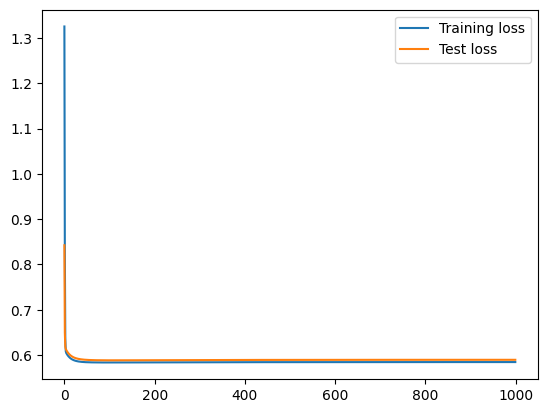

In [25]:
plt.plot(np.arange(len(train_loss)), train_loss, label="Training loss")
plt.plot(np.arange(len(test_loss)), test_loss, label="Test loss")
plt.legend()

Le modèle converge vers une loss de 0.6, ce qui est assez élevé, ce qui nous montre que le modèle traduit mal les données.

De plus le modèle apprend très vite au début, puis n'évolue plus beaucoup. Cela peut s'expliquer par une vectorisation peu pertinente des données.

### [Bonus] The parameter weight_decay of the SGD optimizer corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.

In [26]:
model_2 = LinearRegression(7, 1)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01, weight_decay=0.0001)
train_loss_2, test_loss_2 = training(optimizer_2, model_2)
test(model_2)

Accuracy of training : 0.7102, valid : 0.7018, test : 0.71132


Accuracy de base : training : 0.7102, validation : 0.7024 et test : 0.71128
Accuracy actuelle : training : 0.7102, validation : 0.7018, test : 0.71132

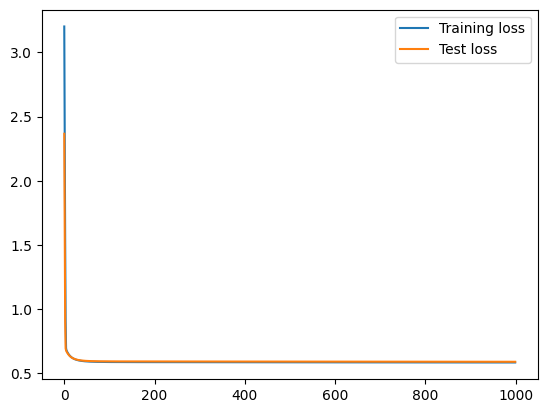

In [27]:
plt.plot(np.arange(len(train_loss_2)), train_loss_2, label="Training loss")
plt.plot(np.arange(len(test_loss_2)), test_loss_2, label="Test loss")
plt.legend()

In [28]:
model_3 = LinearRegression(7, 1)
optimizer_3 = torch.optim.SGD(model_3.parameters(), lr=0.01, weight_decay=2)
train_loss_3, test_loss_3 = training(optimizer_3, model_3)
test(model_3)

Accuracy of training : 0.7097, valid : 0.704, test : 0.71132


Accuracy de base : training : 0.7102, validation : 0.7024 et test : 0.71128
Accuracy actuelle : training : 0.7097, validation : 0.704, test : 0.71132

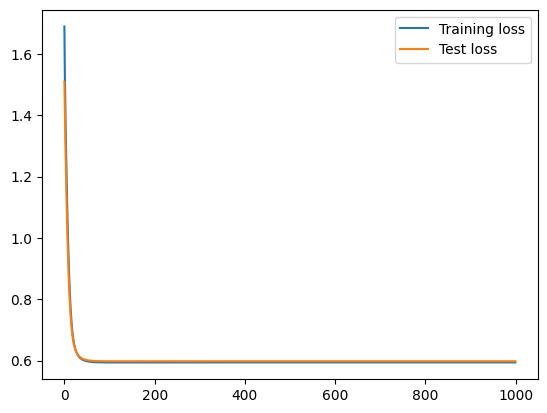

In [29]:
plt.plot(np.arange(len(train_loss_3)), train_loss_3, label="Training loss")
plt.plot(np.arange(len(test_loss_3)), test_loss_3, label="Test loss")
plt.legend()

En modifiant le paramètre weight_decay, on joue à la fois sur la vitessse d'apprentissage et sur la régularisation du réseau neuronal (over/under fitting).

Donc en prenant un weight_decay trop faible, on risque d'avoir un modèle qui overfit, et en prenant un weight_decay trop élevé, on risque d'avoir un modèle qui underfit dans les deux cas, le modèle ne se généralisera pas bien.

Enfin, on remarque qu'avec un weight_decay très faible le réseau met (parfois) plus de temps à converger.

### (1 point) Take two wrongly classified samples in the test set and try explaining why the model was wrong.

In [30]:
def get_wrongly_classified(model : LinearRegression, test_points, test_labels) -> Tuple[list, float]:
    """
    Get wrongly classified samples.
    :param model: The model to test : LinearRegression
    :param test_points: The test points : torch.Tensor
    :param test_labels: The test labels : torch.Tensor
    :return: The wrongly classified samples and the test accuracy : Tuple[list, float]
    """
    with torch.no_grad():
        p_test = torch.sigmoid(model(test_points))
        p_test = np.round(p_test.numpy())
        test_accuracy = np.mean(p_test == test_labels.numpy())
        wrong_classified = np.where(p_test != test_labels.numpy())[0]

    return wrong_classified, test_accuracy

wrong_classified, test_accuracy = get_wrongly_classified(model_1, test_points, test_labels)
print(f'Accuracy of test : {test_accuracy}')
print(f'Number of wrongly classified : {len(wrong_classified)}')

Accuracy of test : 0.71124
Number of wrongly classified : 7219


In [43]:
# instantiate a Pseudo-random number generator (PRNG)
rng = np.random.default_rng(420)

In [44]:
index1 = wrong_classified[int(rng.random() * len(wrong_classified))]
weights1 = test_points[index1]
print(f'Desired label: {int(test_labels[index1])}')
print(f'Has no : {weights1[0]}, count_pronouns : {weights1[1]}, has_exclamative : {weights1[2]}, words_count_log : {weights1[3]} \n'
      f'positive_words : {weights1[4]}, negative_words : {weights1[5]}, words_count_log_minus_stop_words : {weights1[6]}\n')

Desired label: 1
Has no : 0.0, count_pronouns : 0.0, has_exclamative : 0.0, words_count_log : 5.513428688049316 
positive_words : 7.0, negative_words : 12.0, words_count_log_minus_stop_words : 4.8828020095825195



Ici , le poids de la feature "nombre de mots dans le lexique positif" ne suffit pas à compenser le poids des features "nombre de mots dans le lexique négatif" et "nombre de mots dans le lexique négatif sans les stop words" qui sont très élevés. Cela fait que le modèle prédit un label négatif alors que le label attendu est positif.

In [45]:
index2 = int(rng.random() * len(wrong_classified))
weights2 = test_points[wrong_classified[index2]]
print(f'Desired label: {int(test_labels[wrong_classified[index2]])}')
print(f'Has no : {weights2[0]}, count_pronouns : {weights2[1]}, has_exclamative : {weights2[2]}, words_count_log : {weights2[3]} \n'
      f'positive_words : {weights2[4]}, negative_words : {weights2[5]}, words_count_log_minus_stop_words : {weights2[6]}\n')

Desired label: 1
Has no : 0.0, count_pronouns : 8.0, has_exclamative : 0.0, words_count_log : 4.18965482711792 
positive_words : 1.0, negative_words : 0.0, words_count_log_minus_stop_words : 3.178053855895996



Dans ce cas, même si la feature "nombre de mots dans le lexique positif" est présente, le modèle ne la prend pas en compte car le poids de cette feature est très faible comparé à toutes les autres features qui font parties du label négatif.

On peut en déduire que notre vectorisation à du mal à déterminer les commentaires positifs.

### [Bonus] Train logistic regression classifier using the scikit-learn implementation. How does it compare with the PyTorch version?

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logistic_regression = LogisticRegression()
logistic_regression.fit(train_points, train_labels.ravel())

y_pred = logistic_regression.predict(test_points)
print(classification_report(test_labels.ravel(), y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.70      0.71     12500
         1.0       0.71      0.71      0.71     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000



On a une accuracy de 71% sur le test set, ce qui est le même résultat que le modèle PyTorch. Mais Sklearn permet d'avoir facilement un code beaucoup plus concis.